<a href="https://colab.research.google.com/github/PayamCyrus/tomatoes_count/blob/main/mnist_test_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11501568/11490434 [==============================] - 0s 0us/step
1000 [D loss: 0.000005 , acc: 100.00] [G loss: 0.000240]
2000 [D loss: 0.000001 , acc: 100.00] [G loss: 0.000100]
3000 [D loss: 0.000000 , acc: 100.00] [G loss: 0.000050]
4000 [D loss: 0.000000 , acc: 100.00] [G loss: 0.000022]


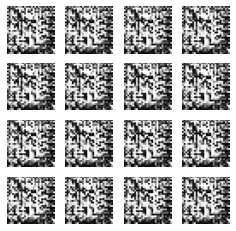

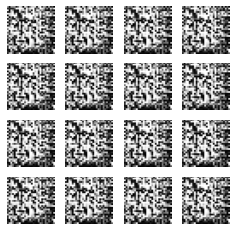

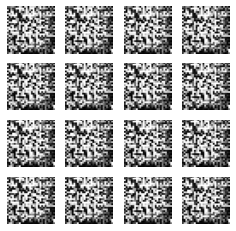

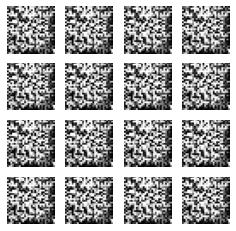

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Activation,BatchNormalization,Dense,Flatten,Reshape
from keras.layers.convolutional import Conv2D,Conv2DTranspose
from keras.layers import LeakyReLU
#from keras.layers.advanced_activations import LeakyReLU
#from keras import LeakyReLU 
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

img_rows=28
img_cols=28
channels=1

img_shape = (img_rows,img_cols,channels)

zdim=100

def build_gen(zdim):
    model = Sequential()
    model.add(Dense(256*7*7,input_dim=zdim))
    model.add(Reshape((7,7,256)))
    
    #14*14*128
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,
                             padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    #14*14*64
    model.add(Conv2DTranspose(64,kernel_size=3,strides=1,
                             padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Conv2DTranspose(1,kernel_size=3,strides=2,
                             padding='same'))
    
    model.add(Activation('tanh'))
    return model

def build_dis(img_shape):
    model=Sequential()
    
    #14*14*32
    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=img_shape,
                    padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    
    #7*7*64
    model.add(Conv2D(64,kernel_size=3,strides=2,input_shape=img_shape,
                    padding='same'))
    
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    
    
    3*3*128
    model.add(Conv2D(128,kernel_size=3,strides=2,input_shape=img_shape,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    return model

    
    
def build_gan(gen,dis):
    model = Sequential()
    model.add(gen)
    model.add(dis)
    return model

dis_v = build_dis(img_shape)
dis_v.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

gen_v = build_gen(zdim)
dis_v.trainable=False
gan_v = build_gan(gen_v,dis_v)
gan_v.compile(loss='binary_crossentropy',
              optimizer=Adam()
             )

losses=[]
accuracies=[]
iteration_checks=[]

def train(iterations,batch_size,interval):

    (Xtrain, _),(_, _) = mnist.load_data()
    Xtrain = Xtrain/127.5 - 1.0
    Xtrain = np.expand_dims(Xtrain,axis=3)

    real = np.ones((batch_size,1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        ids = np.random.randint(0,Xtrain.shape[0],batch_size)
        imgs = Xtrain[ids]

        z=np.random.normal(0,1,(batch_size,100))
        gen_imgs = gen_v.predict(z)

        dloss_real = dis_v.train_on_batch(imgs,real)
        dloss_fake = dis_v.train_on_batch(gen_imgs, fake)

        dloss,accuracy = 0.5 * np.add(dloss_real,dloss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        gloss = gan_v.train_on_batch(z,real)

        if (iteration+1) % interval == 0:
            losses.append((dloss,gloss))
            accuracies.append(100.0*accuracy)
            iteration_checks.append(iteration+1)

            print("%d [D loss: %f , acc: %.2f] [G loss: %f]" %
                  (iteration+1,dloss,100.0*accuracy,gloss))
            show_images(gen_v)


def show_images(gen):
    z = np.random.normal(0, 1, (16, 100))
    gen_imgs = gen.predict(z)
    gen_imgs = 0.5*gen_imgs + 0.5

    fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)

    cnt=0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(gen_imgs[cnt,:,:,0],cmap='gray')
            axs[i, j].axis('off')
            cnt+=1

    fig.show()

train(4000,128,1000)